# Deep Learning 2

## Neural networks in PyTorch

In [1]:
import torch

### Basics

In [2]:
# Create tensors.
x = torch.tensor(1., requires_grad=True)
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(3., requires_grad=True)

# Build a computational graph.
y = w * x + b    # y = 2 * x + 3

# Compute gradients.
y.backward()

# Print out the gradients.
print(x.grad)    # x.grad = 2 
print(w.grad)    # w.grad = 1 
print(b.grad)    # b.grad = 1 

tensor(2.)
tensor(1.)
tensor(1.)


### Linear layer

In [3]:
# Create tensors of shape (10, 3) and (10, 2).
x = torch.randn(10, 3)
y = torch.randn(10, 2)

# Build a fully connected layer.
linear = torch.nn.Linear(3, 2)
print ('w: ', linear.weight)
print ('b: ', linear.bias)

# Build loss function and optimizer.
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(linear.parameters(), lr=0.01)

# Forward pass.
pred = linear(x)

# Compute loss.
loss = criterion(pred, y)
print('loss: ', loss.item())

# Backward pass.
loss.backward()

# Print out the gradients.
print ('dL/dw: ', linear.weight.grad) 
print ('dL/db: ', linear.bias.grad)

# 1-step gradient descent.
optimizer.step()

# You can also perform gradient descent at the low level.
# linear.weight.data.sub_(0.01 * linear.weight.grad.data)
# linear.bias.data.sub_(0.01 * linear.bias.grad.data)

# Print out the loss after 1-step gradient descent.
pred = linear(x)
loss = criterion(pred, y)
print('loss after 1 step optimization: ', loss.item())

w:  Parameter containing:
tensor([[ 0.0163, -0.3440, -0.3229],
        [-0.4780, -0.5244,  0.0510]], requires_grad=True)
b:  Parameter containing:
tensor([-0.2227,  0.1858], requires_grad=True)
loss:  1.6875699758529663
dL/dw:  tensor([[ 0.0678, -0.5688, -0.8132],
        [-0.4000, -0.2334,  0.6753]])
dL/db:  tensor([-0.5654,  0.0536])
loss after 1 step optimization:  1.6678905487060547


### Pytorch Tensors and Numpy

In [4]:
import numpy as np

In [5]:
# Create a numpy array.
x = np.array([[1, 2], [3, 4]])

# Convert the numpy array to a torch tensor.
y = torch.from_numpy(x)

# Convert the torch tensor to a numpy array.
z = y.numpy()

print("Original numpy: ", x, sep="\n")
print("PyTorch tensor: ", y, sep="\n")
print("Converted numpy: ", z, sep="\n")

Original numpy: 
[[1 2]
 [3 4]]
PyTorch tensor: 
tensor([[1, 2],
        [3, 4]])
Converted numpy: 
[[1 2]
 [3 4]]


### Datasets

#### Use external

In [6]:
import torchvision

In [7]:
# Download and construct MNIST dataset.
train_dataset = torchvision.datasets.MNIST(root='data/',
                                             train=True, 
                                             transform=torchvision.transforms.ToTensor(),
                                             download=True)

# Fetch one data pair (read data from disk).
image, label = train_dataset[0]
print(image.size())
print(label)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!
torch.Size([1, 28, 28])
5


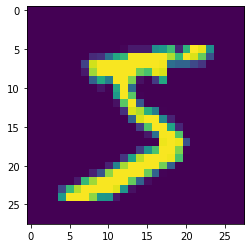

In [9]:
import matplotlib.pyplot as plt
plt.imshow(torchvision.transforms.ToPILImage()(image))

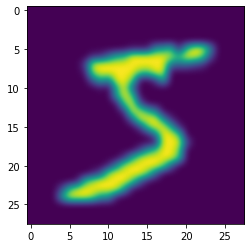

In [10]:
plt.imshow(torchvision.transforms.ToPILImage()(image), interpolation="bicubic")

In [11]:
# Data loader (this provides queues and threads in a very simple way).
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

# When iteration starts, queue and thread start to load data from files.
data_iter = iter(train_loader)

# Mini-batch images and labels.
images, labels = data_iter.next()

# Actual usage of the data loader is as below.
for images, labels in train_loader:
    # Training code should be written here.
    pass

#### Create your own

In [ ]:
# You should build your custom dataset as below.
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self):
        # TODO
        # 1. Initialize file paths or a list of file names. 
        pass
    def __getitem__(self, index):
        # TODO
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        # 2. Preprocess the data (e.g. torchvision.Transform).
        # 3. Return a data pair (e.g. image and label).
        pass
    def __len__(self):
        # You should change 0 to the total size of your dataset.
        # Will be error
        return 0

# You can then use the prebuilt data loader. 
custom_dataset = CustomDataset()
train_loader = torch.utils.data.DataLoader(dataset=custom_dataset,
                                           batch_size=64, 
                                           shuffle=True)

### Models

#### ResNet18

<div style="width:image width px; 
            font-size:80%; 
            text-align:center; 
            float: left; padding-left-right-top-bottom:0.5em;  
            border-style: solid; border-color: rgba(211, 211, 211, 0.000);
            background-color: rgba(0,0, 0, 0.000;">
    <img src="./pics/resnet18.png" 
         alt="alternate text" 
         width=800
         style="padding-bottom:0.5em;"/>
    <div style="padding: 3px; 
                width: 400px; 
                word-wrap: break-word; 
                text-align:justify;">
        Illustration of ResNet18 architecture by Gaurav Singhal. <br> 
        <a href="https://www.pluralsight.com/guides/introduction-to-resnet" 
           style="float: left;"> 
           Source 
        </a>
    </div>
</div>

In [13]:
# Download and load the pretrained ResNet-18.
resnet = torchvision.models.resnet18(pretrained=True)

# If you want to finetune only the top layer of the model, set as below.
for param in resnet.parameters():
    param.requires_grad = False

# Replace the top layer for finetuning.
resnet.fc = torch.nn.Linear(resnet.fc.in_features, 100)  # 100 is an example.

# Forward pass.
images = torch.randn(64, 3, 224, 224)
outputs = resnet(images)
print (outputs.size())     # (64, 100)

torch.Size([64, 100])


In [14]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

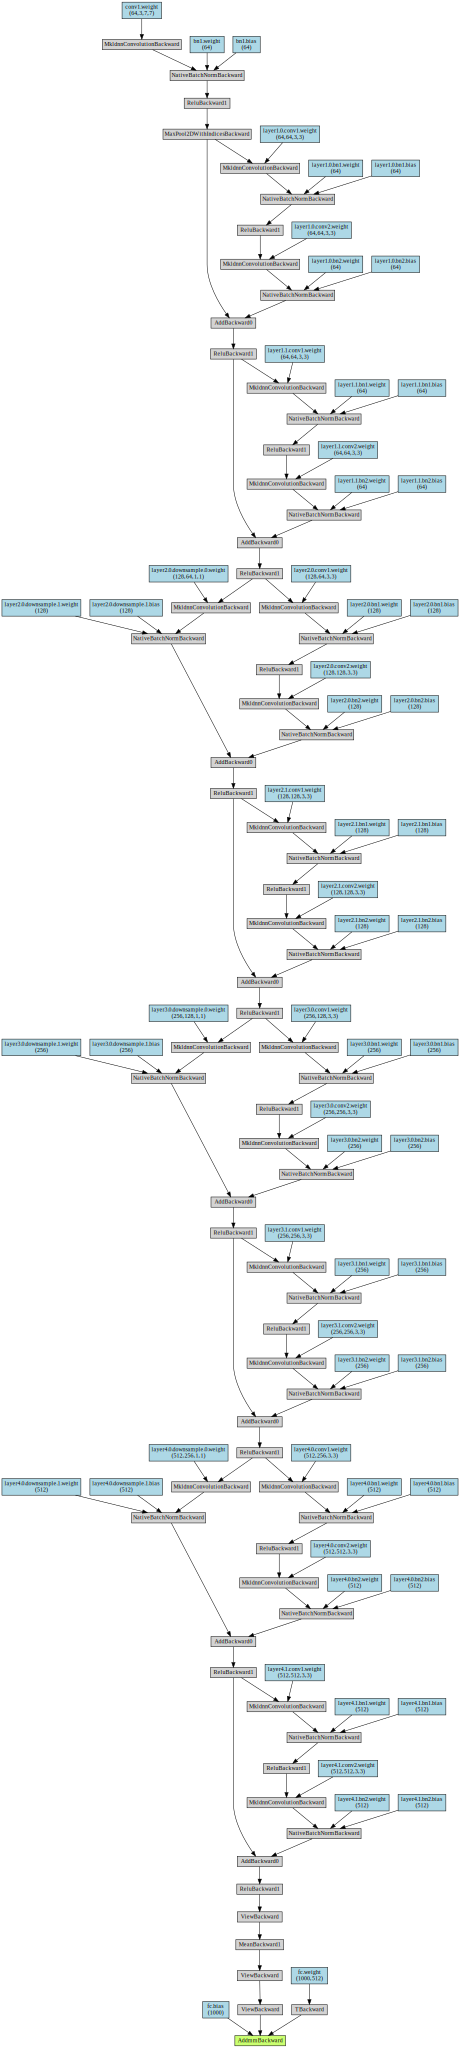

In [15]:
from torchviz import make_dot

resnet = torchvision.models.resnet18(pretrained=True)
images = torch.randn(64, 3, 224, 224)
make_dot(resnet(images), params=dict(list(resnet.named_parameters())))

### Save model

#### Pytorch format

In [16]:
# Save and load the entire model.
torch.save(resnet, 'model.ckpt')
model = torch.load('model.ckpt')

# Save and load only the model parameters (recommended).
torch.save(resnet.state_dict(), 'params.ckpt')
resnet.load_state_dict(torch.load('params.ckpt'))

<All keys matched successfully>

#### ONNX

In [17]:
resnet = torchvision.models.resnet18(pretrained=True)
images = torch.randn(64, 3, 224, 224)
torch.onnx.export(resnet, images, "model.onnx") 

Look at the model: https://netron.app/ (sources: https://github.com/lutzroeder/netron)

## Feedforward Neural Network

Based on https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/01-basics/feedforward_neural_network/main.py

In [18]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/5], Step [100/600], Loss: 0.2368
Epoch [1/5], Step [200/600], Loss: 0.4058
Epoch [1/5], Step [300/600], Loss: 0.1186
Epoch [1/5], Step [400/600], Loss: 0.3634
Epoch [1/5], Step [500/600], Loss: 0.1035
Epoch [1/5], Step [600/600], Loss: 0.1728
Epoch [2/5], Step [100/600], Loss: 0.0800
Epoch [2/5], Step [200/600], Loss: 0.0789
Epoch [2/5], Step [300/600], Loss: 0.1562
Epoch [2/5], Step [400/600], Loss: 0.0506
Epoch [2/5], Step [500/600], Loss: 0.1013
Epoch [2/5], Step [600/600], Loss: 0.0669
Epoch [3/5], Step [100/600], Loss: 0.1527
Epoch [3/5], Step [200/600], Loss: 0.1427
Epoch [3/5], Step [300/600], Loss: 0.0322
Epoch [3/5], Step [400/600], Loss: 0.0972
Epoch [3/5], Step [500/600], Loss: 0.0140
Epoch [3/5], Step [600/600], Loss: 0.0377
Epoch [4/5], Step [100/600], Loss: 0.0572
Epoch [4/5], Step [200/600], Loss: 0.1255
Epoch [4/5], Step [300/600], Loss: 0.0673
Epoch [4/5], Step [400/600], Loss: 0.0345
Epoch [4/5], Step [500/600], Loss: 0.0170
Epoch [4/5], Step [600/600], Loss:

## Convolutional Neural Network

### Structure

<div style="width:image width px; 
            font-size:80%; 
            text-align:center; 
            float: left; padding-left-right-top-bottom:0.5em;  
            border-style: solid; border-color: rgba(211, 211, 211, 0.000);
            background-color: rgba(0,0, 0, 0.000;">
    <img src="./pics/cnn.jpeg" 
         alt="alternate text" 
         width=800
         style="padding-bottom:0.5em;"/>
    <div style="padding: 3px; 
                width: 400px; 
                word-wrap: break-word; 
                text-align:justify;">
        Illustration of CNN architecture example by Sumit Saha. <br> 
        <a href="https://medium.com/towards-artificial-intelligence/whirlwind-tour-of-rnns-a11effb7808f" 
           style="float: left;"> 
           Source 
        </a>
    </div>
</div>

### Convolution

<div style="width:image width px; 
            font-size:80%; 
            text-align:center; 
            float: left; padding-left-right-top-bottom:0.5em;  
            border-style: solid; border-color: rgba(211, 211, 211, 0.000);
            background-color: rgba(0,0, 0, 0.000;">
    <img src="./pics/conv.gif" 
         alt="alternate text" 
         width=800
         style="padding-bottom:0.5em;"/>
    <div style="padding: 3px; 
                width: 400px; 
                word-wrap: break-word; 
                text-align:justify;">
        Illustration of convolution operation on a MxNx3 image matrix with a 3x3x3 Kernel by Sumit Saha. <br> 
        <a href="https://medium.com/towards-artificial-intelligence/whirlwind-tour-of-rnns-a11effb7808f" 
           style="float: left;"> 
           Source 
        </a>
    </div>
</div>

### Pooling

<div style="width:image width px; 
            font-size:80%; 
            text-align:center; 
            float: left; padding-left-right-top-bottom:0.5em;  
            border-style: solid; border-color: rgba(211, 211, 211, 0.000);
            background-color: rgba(0,0, 0, 0.000;">
    <img src="./pics/pooling.gif" 
         alt="alternate text" 
         width=800
         style="padding-bottom:0.5em;"/>
    <div style="padding: 3px; 
                width: 400px; 
                word-wrap: break-word; 
                text-align:justify;">
        Illustration of 3x3 pooling over 5x5 convolved feature by Sumit Saha. <br> 
        <a href="https://medium.com/towards-artificial-intelligence/whirlwind-tour-of-rnns-a11effb7808f" 
           style="float: left;"> 
           Source 
        </a>
    </div>
</div>

#### Types of pooling

<div style="width:image width px; 
            font-size:80%; 
            text-align:center; 
            float: left; padding-left-right-top-bottom:0.5em;  
            border-style: solid; border-color: rgba(211, 211, 211, 0.000);
            background-color: rgba(0,0, 0, 0.000;">
    <img src="./pics/pooling_types.png" 
         alt="alternate text" 
         width=800
         style="padding-bottom:0.5em;"/>
    <div style="padding: 3px; 
                width: 400px; 
                word-wrap: break-word; 
                text-align:justify;">
        Illustration of types of Pooling by Sumit Saha. <br> 
        <a href="https://medium.com/towards-artificial-intelligence/whirlwind-tour-of-rnns-a11effb7808f" 
           style="float: left;"> 
           Source 
        </a>
    </div>
</div>

### Example

Based on Based on https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/convolutional_neural_network/main.py

In [19]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/5], Step [100/600], Loss: 0.1629
Epoch [1/5], Step [200/600], Loss: 0.1493
Epoch [1/5], Step [300/600], Loss: 0.0693
Epoch [1/5], Step [400/600], Loss: 0.0765
Epoch [1/5], Step [500/600], Loss: 0.0350
Epoch [1/5], Step [600/600], Loss: 0.0281
Epoch [2/5], Step [100/600], Loss: 0.0456
Epoch [2/5], Step [200/600], Loss: 0.0347
Epoch [2/5], Step [300/600], Loss: 0.0373
Epoch [2/5], Step [400/600], Loss: 0.0661
Epoch [2/5], Step [500/600], Loss: 0.0325
Epoch [2/5], Step [600/600], Loss: 0.0119
Epoch [3/5], Step [100/600], Loss: 0.0642
Epoch [3/5], Step [200/600], Loss: 0.0269
Epoch [3/5], Step [300/600], Loss: 0.0911
Epoch [3/5], Step [400/600], Loss: 0.0205
Epoch [3/5], Step [500/600], Loss: 0.0665
Epoch [3/5], Step [600/600], Loss: 0.0552
Epoch [4/5], Step [100/600], Loss: 0.0081
Epoch [4/5], Step [200/600], Loss: 0.0028
Epoch [4/5], Step [300/600], Loss: 0.0132
Epoch [4/5], Step [400/600], Loss: 0.0819
Epoch [4/5], Step [500/600], Loss: 0.0060
Epoch [4/5], Step [600/600], Loss:

## Recurrent Neural Network

<div style="width:image width px; 
            font-size:80%; 
            text-align:center; 
            float: left; padding-left-right-top-bottom:0.5em;  
            border-style: solid; border-color: rgba(211, 211, 211, 0.000);
            background-color: rgba(0,0, 0, 0.000;">
    <img src="./pics/rnn.png" 
         alt="alternate text" 
         width=800
         style="padding-bottom:0.5em;"/>
    <div style="padding: 3px; 
                width: 400px; 
                word-wrap: break-word; 
                text-align:justify;">
        Illustration of The architecture of an RNN by Ben Khuong. <br> 
        <a href="https://medium.com/towards-artificial-intelligence/whirlwind-tour-of-rnns-a11effb7808f" 
           style="float: left;"> 
           Source 
        </a>
    </div>
</div>

### LSTM

**(Long-short term memory)**

A recurrent neural network is a network that maintains some kind of state. For example, its output could be used as part of the next input, so that information can propogate along as the network passes over the sequence.

In the case of an LSTM, for each element in the sequence, there is a corresponding hidden state, which in principle can contain information from arbitrary points earlier in the sequence. We can use the hidden state to predict words in a language model, part-of-speech tags, and a myriad of other things.

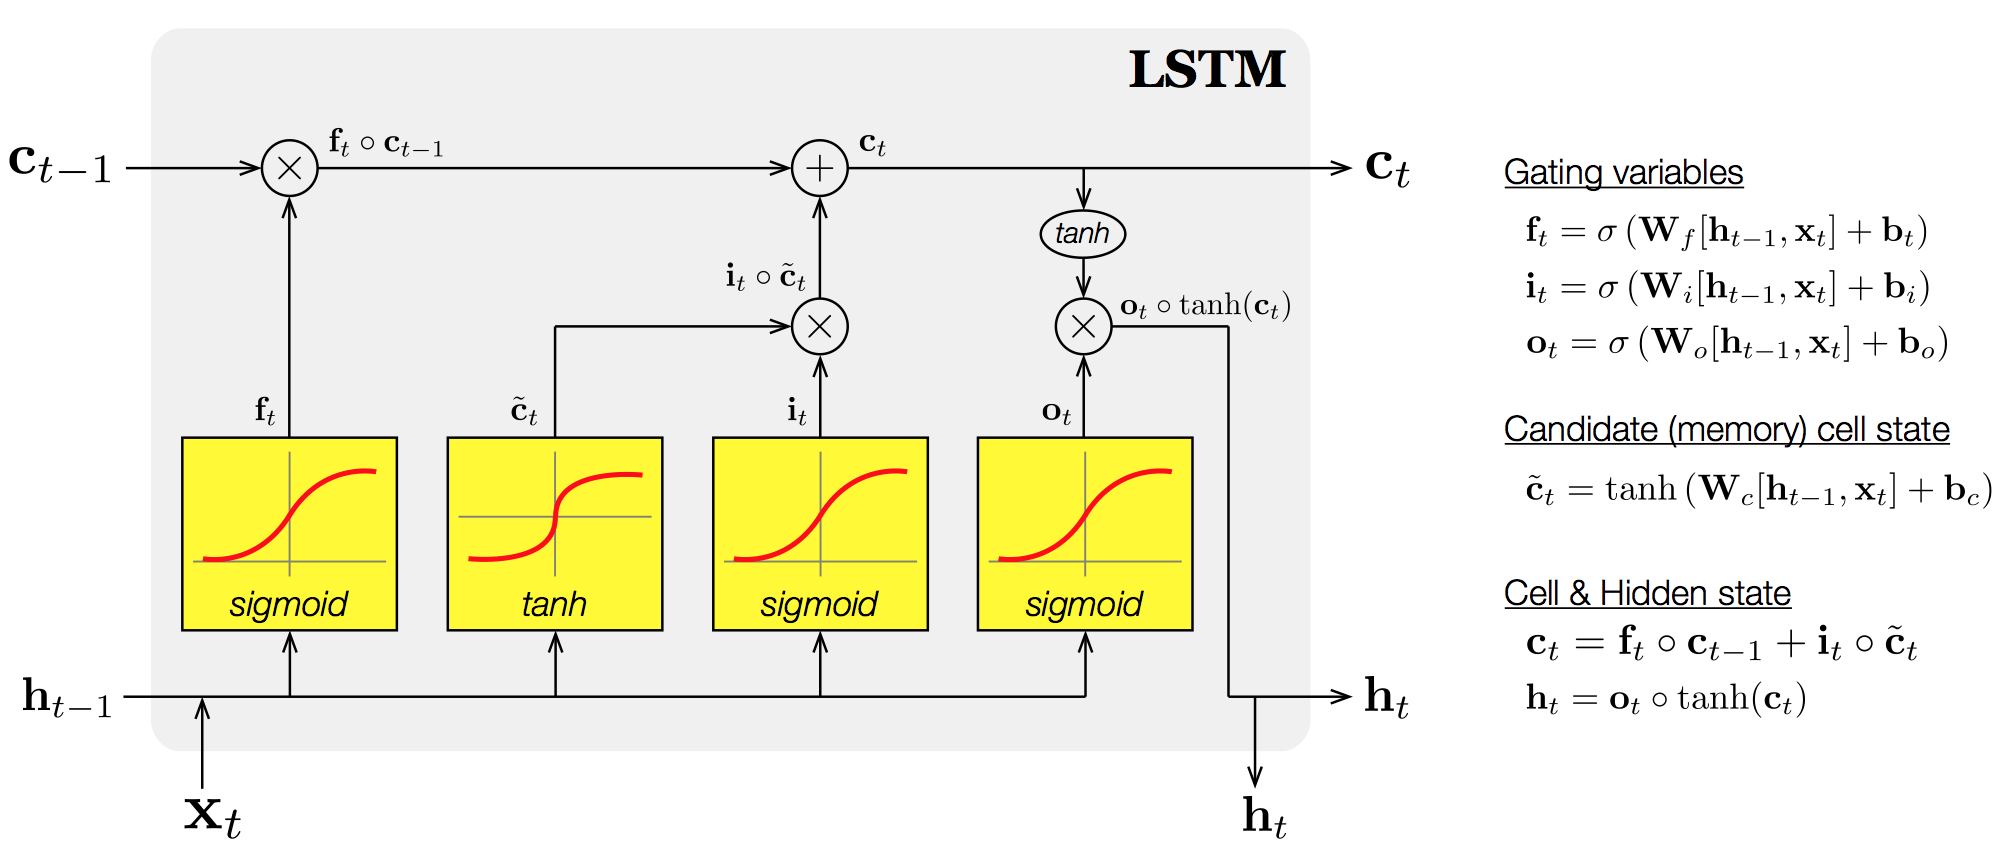

### Example

Based on https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/recurrent_neural_network/main.py

In [20]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/2], Step [100/600], Loss: 0.7713
Epoch [1/2], Step [200/600], Loss: 0.4131
Epoch [1/2], Step [300/600], Loss: 0.2561
Epoch [1/2], Step [400/600], Loss: 0.1807
Epoch [1/2], Step [500/600], Loss: 0.0818
Epoch [1/2], Step [600/600], Loss: 0.0373
Epoch [2/2], Step [100/600], Loss: 0.2168
Epoch [2/2], Step [200/600], Loss: 0.0800
Epoch [2/2], Step [300/600], Loss: 0.0439
Epoch [2/2], Step [400/600], Loss: 0.0980
Epoch [2/2], Step [500/600], Loss: 0.0528
Epoch [2/2], Step [600/600], Loss: 0.1141
Test Accuracy of the model on the 10000 test images: 97.51 %


In [21]:
%reload_ext watermark
%watermark -d -u -v -iv

numpy       1.18.1
torchvision 0.5.0
torch       1.4.0
last updated: 2020-10-24 

CPython 3.8.0
IPython 7.13.0


## References

1. https://github.com/yunjey/pytorch-tutorial/
2. https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53